The goal of this notebook is to determine the cumulative fraction of each basin that has been burned over the timeframe of the fire data.

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np

Here is the fire data from Matt:

In [2]:
# Import fire data
f=gpd.read_file("LAC_fires.geojson")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<AxesSubplot: >

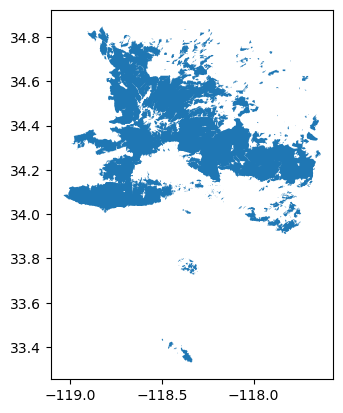

In [3]:
f.plot()

To import the hydrologic basins, I need a bounding box

In [4]:
bbox = (-118.9441,32.8065,-117.6447,34.8227) # Source: https://observablehq.com/@rdmurphy/u-s-county-bounding-boxes-by-state

In [5]:
b=gpd.read_file("../week5/data/BasinATLAS_Data_v10.gdb.zip", driver='FileGDB', layer='BasinATLAS_v10_lev12',bbox=bbox)

What I want to do now is use the `intersection` function in geopandas to find the area of each fire-to-basin overlap and sum those areas for each basin. For example, if a basin was 20% burned by one first and 15% burned by another, I want a number that scales with 35% -- regardless of whether or not the two fires themselves overlap (because, probably, they happened far enough apart... a more advanced version would add a recovery curve).

There is probably a better way to do this, but one method is to transform both geodataframes into lists with one basin (or fire) per list entry and then use "list comprehension" syntax to map the pairs through the intersection calculation:

In [6]:
# Create a list "basins" with one entry per basin
basins = []
for i in list(range(0,b.shape[0])):
    basins.append([b.iloc[i]])

In [7]:
# Create a list "fires" with one entry per fire
fires = []
for i in list(range(0,f.shape[0])):
    fires.append([f.iloc[i]])

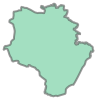

In [8]:
# Just to verity that each item retains geometry information:
fires[0][0]["geometry"]

In [9]:
# Triplet of functions to aggregate intersections
def f1(a,b):
    return a[0]["geometry"].intersection(b[0]["geometry"]).area
def f2(b,aa):
    return sum([f1(a,b) for a in aa])
def f3(aa,bb):
    return [f2(b,aa) for b in bb]

In [42]:
# Compute the area of fire intersection in each basin
burned=f3(fires,basins)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Okay. `burned` should be a list with one entry per basin, with the entry being the cumulative burned area. Let's make sure there is one entry per basin:

In [43]:
print(len(burned))
print(len(basins))
print(b.shape[0])

135
135
135


Next, I want to assign each cumulative burned area to each basin:

In [45]:
b["burnt"] = burned

Let's see if that worked!

<AxesSubplot: >

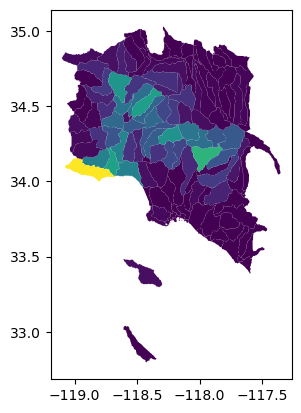

In [46]:
b.plot(column=b["burnt"])

Good -- the fires are in the hills!

What I want to do next is calculate for each basin the total area (and burnt area) in the basin and *upstream* of the basin. Basin on the network diagrams from last week, I know that there is no partitioning of upstream basins -- each basin ***U*** has exactly one downstream basin ***D***.

The basin data already have a column providing the immediate *downstream* basin for each basin. I need to add a column with the immediate *upstream* basin(s).

In [14]:
def get_id(basin):
    return basin[0][0]
ids = [get_id(basin) for basin in basins]
def get_down(basin):
    return basin[0][1]
downs = [get_down(basin) for basin in basins]


In [15]:
# Create a square zero array with dimensions matching the number of basins
up = np.zeros((len(basins),len(basins)))

In [16]:
up = np.identity(len(basins))

In [17]:
# Each basin has a row and a column. If basin a flows into basin b, set up[b,a] = 1.
# This is now a square matrix showing all immediate upstream connections
for d in range(0,len(downs)):
    if downs[d]!=0:
        try:
            up[ids.index(downs[d])][d]=1
        except:
            1+1

In [18]:
def subit(z):
    return [i for i, x in enumerate(up[z]) if x == 1]

In [71]:
# Now iterate through the matrix of immediate upstream connections to find
# basins upstream of upstream basins, basins upstream of basins upstream of upstream basins, etc
# Create update up array so up[b][a]=1 if a is upstream of b

for i0 in range(0,len(basins)):
    x = list([i0])
    i1 = subit(i0)
    for z in i1:
        x.append(z)
        i2 = subit(z)
        for z in i2:
            x.append(z)
            i3 = subit(z)
            for z in i3:
                x.append(z)
                i4 = subit(z)
                for z in i4:
                    x.append(z)
                    i5 = subit(z)
                    for z in i5:
                        x.append(z)
                        i6 = subit(z)
                        for z in i6:
                            x.append(z)
                            i7 = subit(z)
                            for z in i7:
                                x.append(z)
                                i8 = subit(z)
                                for z in i8:
                                    x.append(z)
                                    i9 = subit(z)
                                    for z in i9:
                                        x.append(z)
                                        i10 = subit(z)
                                        for z in i10:
                                            x.append(z)
    up[i0][x]=1

In [74]:
# Let's check one...
up[40]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
# Calculate the total area burned upstream of the basin
def calc_burnup(i):
    return sum(np.multiply(up[i],burned))

In [76]:
burnup = [calc_burnup(i) for i in range(0,len(basins))]

In [77]:
b["burnup"]=burnup

<AxesSubplot: >

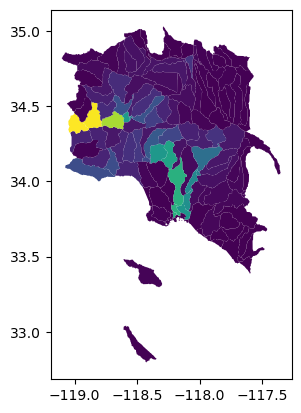

In [78]:
b.plot(column="burnup")

<AxesSubplot: >

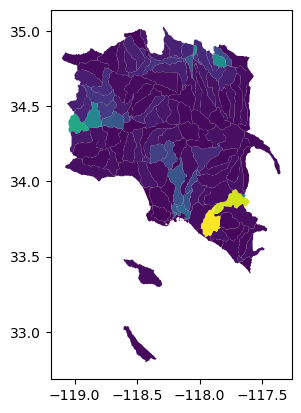

In [80]:
b.plot(column="UP_AREA")

In [81]:
b["fburnt"]=b["burnup"]/b["UP_AREA"]

<AxesSubplot: >

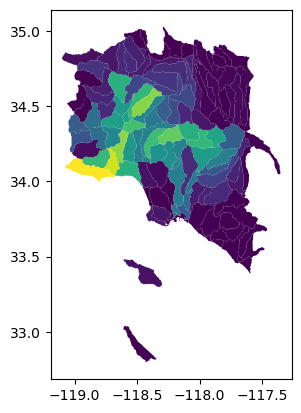

In [82]:
b.plot(column="fburnt")

Now I can iteratively pull basins upstream of the upstream basins into a column of all upstream basins. The following is super inefficient computationally, but probably acceptable:

Now we can sum the total and burnt area in the upstream basins:

In [ ]:
# for each basins, find the fraction of watershed burnt
for basin in b:
    basin[“burnup”] = sum(b[b[“id”] = basin[“up”]][“burnt”])
    basin[“areaup”] = sum(b[b[“id”] = basin[“up”]].area)
    basin[“fburnt”] = (basin[“burnup”)+basin[“burnt”])/(basin[“areaup”]+basin.area)

Let's see if that worked!

In [ ]:
b.plot(column="fburnt")